In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from model import NeuralNetwork, NeuralNetwork_Adjustable
from utils import count_parameters, plot_metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn import metrics

import matplotlib.pyplot as plt
from IPython.display import clear_output

from time import time

import gc

In [2]:
sample_size  = int(1e+6)
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data') 
#print(df)
df = df.astype(np.float32)  
#df = df.loc[df['jet_flavor'] == 5.0, :]   # Bottoms
df_charm = df.loc[df['jet_flavor'] == 4.0, :] 
df_light = df.loc[df['jet_flavor'] == 1.0, :] 

df = pd.concat([df_charm,df_light], axis=0)

df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta'])
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]

df.replace({"inf": 0, "-inf": 0}, inplace=True)
df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]

inputs = df[input_col_names]

del df
gc.collect()

train_inputs, val_inputs = train_test_split(inputs, test_size = 0.2, shuffle = True, random_state = 42)  # stratify ?

del inputs
gc.collect()

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)

batchsize = int(len(train_inputs)/100)
print(batchsize)
trainloader = DataLoader(train_inputs, batch_size = batchsize , drop_last=True )

          jet_pt   jet_eta  jet_flavor  hl_trck_var_trck_2_d0_sig   
0      25.885900 -1.202390         4.0                   0.874096  \
1      29.147499 -1.195630         4.0                   0.634279   
2      25.676399  1.203180         4.0                   0.817854   
3      23.573601  1.678740         4.0                   3.722150   
4      23.941700 -0.398695         4.0                   2.123460   
...          ...       ...         ...                        ...   
99995  26.228500 -0.663639         4.0                   0.935804   
99996  24.043301 -1.391860         4.0                   3.276130   
99997  35.396500 -0.421217         4.0                   0.899555   
99998  26.479300  1.636440         4.0                   0.416047   
99999  24.644400  1.417870         4.0                   5.601360   

       hl_trck_var_trck_3_d0_sig  hl_trck_var_trck_2_z0_sig   
0                       0.198877                   0.327153  \
1                       0.508459             

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, code):
        super(Autoencoder, self).__init__()
        mult=int((input_size/code)**(0.33334))       # change the cube root if you want to change number of layers
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, code*mult*mult),
            torch.nn.ReLU(),
            #torch.nn.Linear(code*mult*mult*mult, code*mult*mult),
            #torch.nn.ReLU(),
            torch.nn.Linear(code*mult*mult, code*mult),
            torch.nn.ReLU(),
            torch.nn.Linear(code*mult, code),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(code, code*mult),
            torch.nn.ReLU(),
            torch.nn.Linear(code*mult, code*mult*mult),
            torch.nn.ReLU(),
           # torch.nn.Linear(code*mult*mult, code*mult*mult*mult),
            #torch.nn.ReLU(),
            torch.nn.Linear(code*mult*mult, input_size),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        #x = self.decoder(x)   # call decoder in train loop to get encoder only
        return x

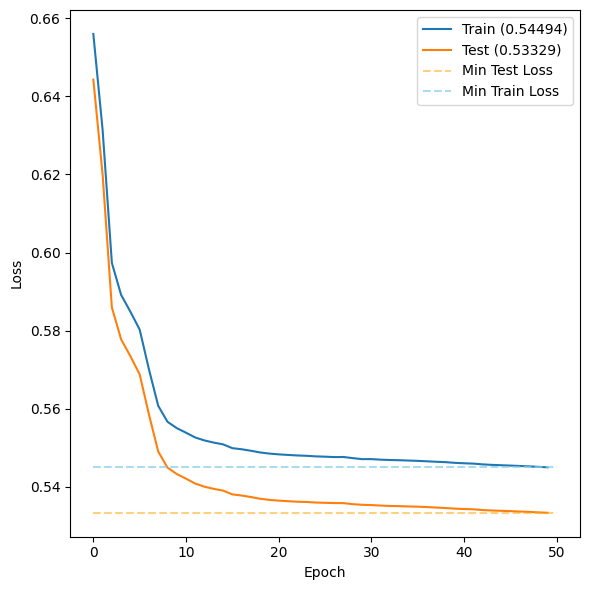

Training complete


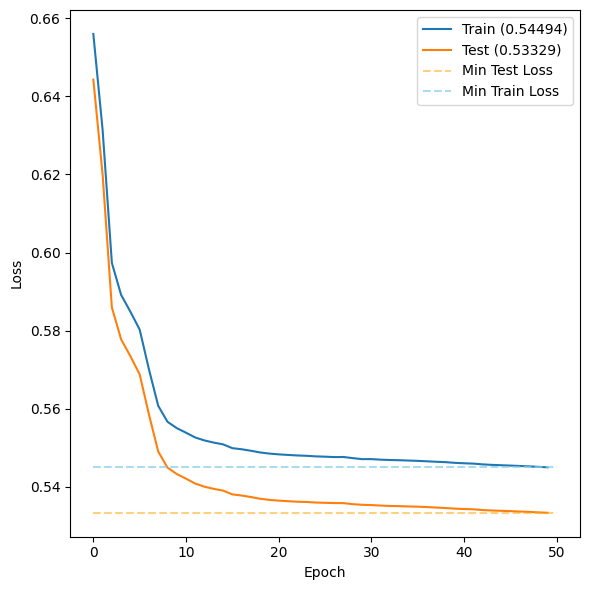

In [8]:
num_epochs = 50
learning_rate = 0.0001         #0.003
input_size  = len(input_col_names)
latent_size = 256

autoencoder = Autoencoder(input_size=input_size, code=latent_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.7)


train_losses = []
val_losses = []
fig, axs = plt.subplots(1, figsize=(6, 6))
for i_epoch in range(num_epochs):
    autoencoder.train() 
    for i_batch,train_input in enumerate(trainloader):
        train_input = train_input.float()
        optimizer.zero_grad()
        
        encoded = autoencoder(train_input)
        train_pred = autoencoder.decoder(encoded)
        loss = criterion(train_pred, train_input)
        
        if not torch.isnan(loss): 
            loss.backward()
            optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        encoded = autoencoder(train_inputs)
        train_preds = autoencoder.decoder(encoded)
        
        val_encoded = autoencoder(val_inputs)
        val_preds = autoencoder.decoder(val_encoded)
   
        train_loss = criterion(train_preds, train_inputs)
        val_loss = criterion(val_preds, val_inputs)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
    scheduler.step()

    axs.clear()
    axs.plot(train_losses, label='Train ({:.5f})'.format(train_losses[-1]))
    axs.plot(val_losses, label='Test ({:.5f})'.format(val_losses[-1]))
    axs.plot([0, len(train_losses)], [min(val_losses), min(val_losses)], '--', color='orange' ,alpha=0.5, label='Min Test Loss')
    axs.plot([0, len(train_losses)], [min(train_losses), min(train_losses)], '--', color = 'skyblue',alpha=0.7, label='Min Train Loss')
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Loss')
    axs.legend()
    
    fig.tight_layout()
    clear_output(wait=True)
    display(fig)

print('Training complete')


In [9]:
del train_inputs, val_inputs, trainloader, val_losses, train_losses
gc.collect()

4625

In [10]:

################################################################ device settings ################################################################
dtype  = 'np.float32'
device = device = "cpu" if torch.backends.mps.is_available() else "cpu"   #torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
print(f'Selected device: {device}')
################################################################ Data Preparation ################################################################
sample_size  = int(1e+6)
print('Preparing data...')
start = time()
       
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data', dtype=dtype)   
df = df.astype(np.float32)  
df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta']) 

Selected device: cpu
Preparing data...


In [11]:
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]
df.replace({"inf": 0, "-inf": 0}, inplace=True)

df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]

inputs = df[input_col_names]
labels = df[target_col_name] 
labels = (labels==5).astype(int)  # changes to 1 or 0

del df
gc.collect()

0

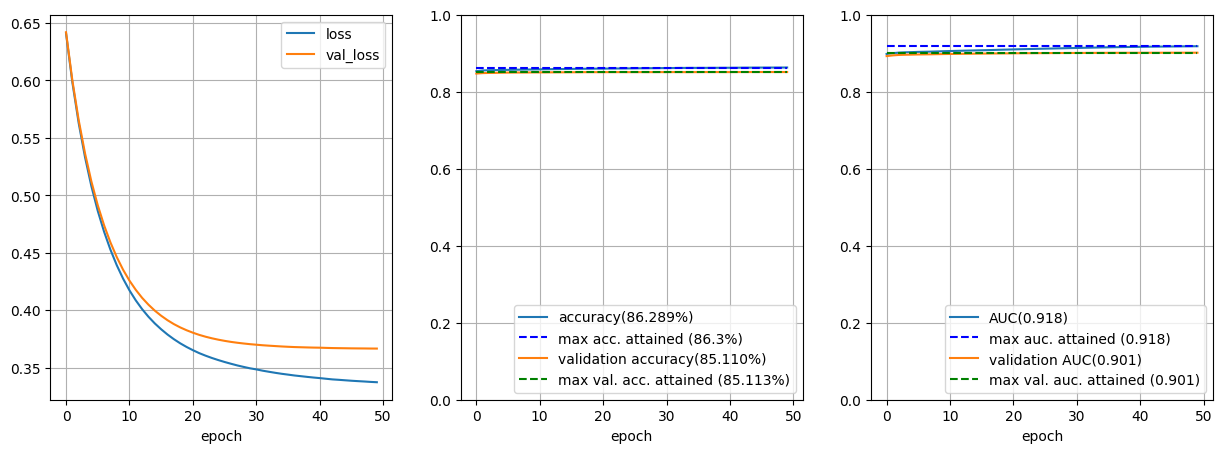

In [12]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=42)

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs = scaler.transform(val_inputs)

train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)


params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc']
}

num_rounds = 50
eval_results = {} 


autoencoder.to('cpu')  # Move the autoencoder to the CPU
autoencoder.eval()     # Set the autoencoder to evaluation mode

with torch.no_grad():
    encoded_train = autoencoder.encoder(train_inputs).detach().numpy()
    encoded_val = autoencoder.encoder(val_inputs).detach().numpy()

# Convert the encoded features to DMatrix objects
dtrain_autoencoder = xgb.DMatrix(encoded_train, label=train_labels)
dval_autoencoder = xgb.DMatrix(encoded_val, label=val_labels)

model = xgb.train(params, dtrain_autoencoder, num_rounds, evals=[(dtrain_autoencoder, 'train'), (dval_autoencoder, 'validation')], evals_result=eval_results)

  

train_losses = eval_results['train']['logloss']
val_losses = eval_results['validation']['logloss']
train_errors = eval_results['train']['error']
val_errors = eval_results['validation']['error']
train_aucs = eval_results['train']['auc']
val_aucs = eval_results['validation']['auc']
train_accuracies = [1 - error for error in train_errors]
val_accuracies = [1 - error for error in val_errors]

plot_metrics(np.arange(num_rounds),train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs)


In [ ]:
'''
autoencoder.to('cpu')  # Move the autoencoder to the CPU
autoencoder.eval()     # Set the autoencoder to evaluation mode

with torch.no_grad():
    encoded_train = autoencoder.encoder(train_inputs).detach().numpy()
    encoded_val = autoencoder.encoder(val_inputs).detach().numpy()

# Convert the encoded features to DMatrix objects
dtrain_autoencoder = xgb.DMatrix(encoded_train, label=train_labels)
dval_autoencoder = xgb.DMatrix(encoded_val, label=val_labels)

model = xgb.train(params, dtrain_autoencoder, num_rounds, evals=[(dtrain_autoencoder, 'train'), (dval_autoencoder, 'validation')], evals_result=eval_results)
'''
